In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [ ]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

In [ ]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

In [ ]:
# Plot just the "Price" column from the dataframe:
# YOUR CODE HERE!
cad_jpy_df.Price.plot()

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** The volatility gets lower and the long-term trend seems mean-reverting 

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [ ]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
# YOUR CODE HERE!
ts_noise, ts_trend = sm.tsa.filters.hpfilter(cad_jpy_df['Price'])
ts_noise


In [ ]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!
df=cad_jpy_df['Price'].to_frame()
df['Trend']=ts_trend
df['Noise']=ts_noise
df.head()

In [ ]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
# YOUR CODE HERE!
df2=df.loc['2015':]


fig = plt.figure(figsize=(12,6)) 

plt.plot(df2[['Price']],label='Price')
plt.plot(df2[['Trend']],label='Trend')
plt.title('CAD/JPY')
plt.legend() 

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** The exchange rate is in a downward trend since 2015

In [ ]:
# Plot the Settle Noise
# YOUR CODE HERE!
fig = plt.figure(figsize=(12,6)) 
plt.plot(df2[['Noise']])
plt.title('Noise')


---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [ ]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

In [ ]:
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!
model=ARMA(returns.values, order=(2, 1))
# Fit the model and assign it to a variable called results
# YOUR CODE HERE!
results=model.fit()

In [ ]:
# Output model summary results:
# YOUR CODE HERE!
results.summary()

In [ ]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

**Question:** Based on the p-value, is the model a good fit?

**Answer:** On 95% significant level, the coefficients of AR(1) and MA(1) are significant but AR(2) and the constant are not.

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!
model2=ARIMA(cad_jpy_df["Price"], order=(5,1,1))
# Fit the model
# YOUR CODE HERE!
results2=model2.fit()
# Output model summary results:
# YOUR CODE HERE!
summary2=results2.summary()
summary2

In [ ]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!
pd.DataFrame(results2.forecast(steps=5)[0]).plot(title='5 Day Price Forecast')

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** Trending downwards

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [49]:
import arch as arch

In [50]:
# Estimate a GARCH model:
# YOUR CODE HERE!
model3=arch.arch_model(returns['Price'], mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
# YOUR CODE HERE!
result3=model3.fit(disp="off")

In [51]:
# Summarize the model results
# YOUR CODE HERE!
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Sun, May 01 2022   Df Residuals:                     7928
Time:                        11:35:43   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [52]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [54]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
# YOUR CODE HERE!
forecast_garch=result3.forecast(start=last_day,horizon=forecast_horizon)

In [55]:
# Annualize the forecast
intermediate = np.sqrt(forecast_garch.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566029,12.573718,12.581301,12.588778,12.596153


In [59]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566029
h.2,12.573718
h.3,12.581301
h.4,12.588778
h.5,12.596153


<AxesSubplot:title={'center':'5 Day Forecast of Volatility'}>

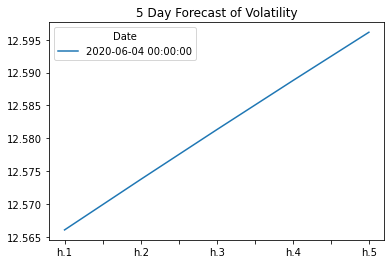

In [60]:
# Plot the final forecast
# YOUR CODE HERE!
final.plot(title='5 Day Forecast of Volatility')

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** Increasing Volatility

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * No, the daily return is expected to be negative and the currency itself is forecasted to depreciate in the near future

2. Is the risk of the yen expected to increase or decrease?
    * Increase

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * No, all of the models contain insignificant terms. Would need to adjust the lag terms and try other models.